


Epoch 1/3000


22/22 [==============================] - 0s 763us/step - loss: 3.5451 - mae: 1.5795 - mse: 3.5451
Epoch 2/3000
22/22 [==============================] - 0s 760us/step - loss: 0.6168 - mae: 0.6270 - mse: 0.6168
Epoch 3/3000
22/22 [==============================] - 0s 643us/step - loss: 0.4052 - mae: 0.5049 - mse: 0.4052
Epoch 4/3000
22/22 [==============================] - 0s 691us/step - loss: 0.3245 - mae: 0.4614 - mse: 0.3245
Epoch 5/3000
22/22 [==============================] - 0s 667us/step - loss: 0.2753 - mae: 0.4361 - mse: 0.2753
Epoch 6/3000
22/22 [==============================] - 0s 700us/step - loss: 0.2473 - mae: 0.4169 - mse: 0.2473
Epoch 7/3000
22/22 [==============================] - 0s 662us/step - loss: 0.2277 - mae: 0.4011 - mse: 0.2277
Epoch 8/3000
22/22 [==============================] - 0s 592us/step - loss: 0.2161 - mae: 0.3925 - mse: 0.2161
Epoch 9/3000
22/22 [==============================] - 0s 673us/step - loss: 0.2045 - mae: 0.3757 - mse: 0.2

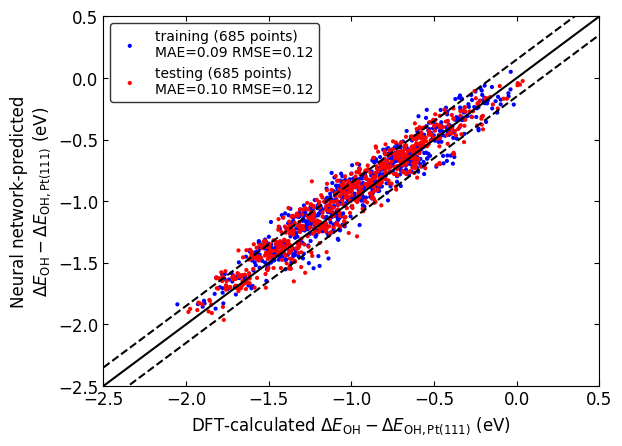

In [2]:
import numpy as np

### Loading data from csv file ###
inputs, outputs = [], [];
# For simplicity and reduced depedency on other libraries, we did not use
# popular Python libraries (e.g. Pandas) to open the csv file, but instead
# we processed the raw csv file in a customized way
with open('data.csv') as f:
  for l in f.readlines():
    # excluding the last character, which is newline character
    l = l[:-1]
    items = l.split(',')
    # excluding the first 2 items, which are the labels of the row,
    # and transforming column 3 and onward to numerical values
    items = list(map(float, items[2:]))
    # column 3 to the second last column are input data (see SI for details)
    inputs.append(items[:-1])
    # the last column is the output data, which is the binding energy of OH*
    outputs.append(items[-1])
# reshaping the outputs such that the input data has the dimensions:
# (number of DFT calculations, number of atoms in each calculation, number of 
#  features for each atom)
# number of features for each atom = 5 (see paper for details)
inputs = np.array(inputs).reshape((len(outputs), -1, 5))
outputs = np.array(outputs)

### Training ###
import tensorflow as tf
from random import shuffle
TRAINING_RATIO = 0.5
training_num = int(TRAINING_RATIO * len(outputs))
rand_idx = list(range(len(inputs))); shuffle(rand_idx)
inputs = inputs[rand_idx]; outputs = outputs[rand_idx]
x_train, y_train = inputs[:training_num], outputs[:training_num]
x_test, y_test = inputs[training_num:], outputs[training_num:]

class MyModel(tf.keras.Model):
  def __init__(self, ):
    super(MyModel, self).__init__()
    self.w1 = tf.keras.layers.Dense(6, activation='tanh', use_bias=False)   
    self.w3 = tf.keras.layers.Dense(1, activation='linear', use_bias=False)
  def call(self, inputs):
    x = self.w1(inputs)
    x = self.w3(x)
    return tf.math.reduce_sum(x, axis=1,)

model = MyModel()

model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])

h = model.fit(x_train, y_train, epochs=3000, callbacks=[], )

if 'results' not in vars():
  results = []
y = model.evaluate(x_test, y_test, verbose=2)

### Ploting results ###
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.scatter(y_train, model(x_train.astype('float32')).numpy().reshape(-1),
  color='blue', marker='.', alpha=1, edgecolors='None')
plt.scatter(y_test, model(x_test.astype('float32')).numpy().reshape(-1), 
  color='red',  marker='.', alpha=1, edgecolors='None')
plt.legend(['training (%i points)\nMAE=%.2f RMSE=%.2f'%
               (len(x_train), h.history['mae'][-1], h.history['mse'][-1]**0.5), \
            'testing (%i points)\nMAE=%.2f RMSE=%.2f'%
               (len(x_test), y[1], y[2]**0.5)], fontsize=10, loc='upper left')\
            .get_frame().set_edgecolor('k')
plt.plot([-2.5,0.5], [-2.5,0.5], 'k')
plt.plot([-2.5,0.5], [-2.35,0.65], 'k--')
plt.plot([-2.5,0.5], [-2.65,0.35], 'k--')
plt.xlabel(r'DFT-calculated $\Delta E_{\mathrm{OH}}-\Delta E_{\mathrm{OH, Pt(111)}}$ (eV)')
plt.ylabel('Neural network-predicted\n'+
           r'$\Delta E_{\mathrm{OH}}-\Delta E_{\mathrm{OH, Pt(111)}}$ (eV)')
plt.xlim([-2.5, 0.5]); plt.ylim([-2.5,0.5])
plt.box(on=True)
plt.tick_params(direction='in', right=True, top=True)
plt.show()